# all credits to https://github.com/alsnhll/SEIR_COVID19

This is an scenario run to track and evaluate the South Australia unfolding of COVID-19 infection against SEIR model

DISCLAIMER: Not to be used as public policy. This is just my own calculation for personal use and share data analysis content for awareness and critic from public

In [52]:
# import packages

import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.pyplot import FuncFormatter
from datetime import datetime

In [2]:
#Defining the differential equations

#Don't track S because all variables must add up to 1 
#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)

def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

In [3]:
# Define parameters based on clinical observations

#I will add sources soon
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days


In [4]:
# Define parameters and run ODE

N=1000
b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3)

a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

#b=2e-4*np.ones(4) # all stages transmit equally
b=2.5e-4*np.array([0,1,0,0]) # hospitalized cases don't transmit

#Calculate basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print("R0 = {0:4.1f}".format(R0))

R0 =  2.5


In [5]:
print(b)
print(a)
print(g)
print(p)
print(u)

[0.      0.00025 0.      0.     ]
0.2
[0.         0.08       0.06818182 0.08571429]
[0.         0.02       0.02272727]
0.057142857142857134


In [6]:
tmax=365
tvec=np.arange(0,tmax,0.1)
ic=np.zeros(6)
ic[0]=1

soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))



(1, 1000)

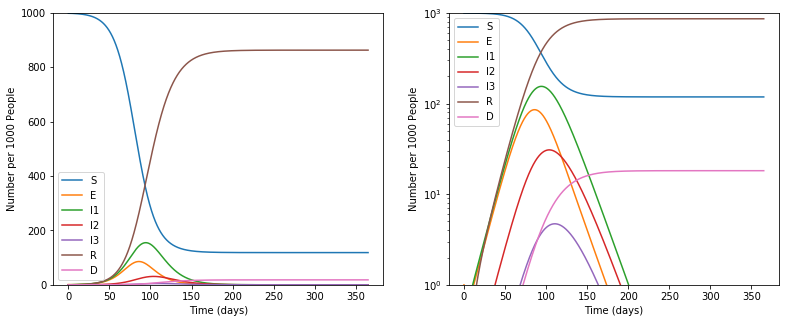

In [7]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000])
#plt.tight_layout()

In [8]:
# South Australia Population

sa = 1600000
factor = sa/1000
factor

1600.0

In [9]:
solnSA = soln * factor

(1, 1600000.0)

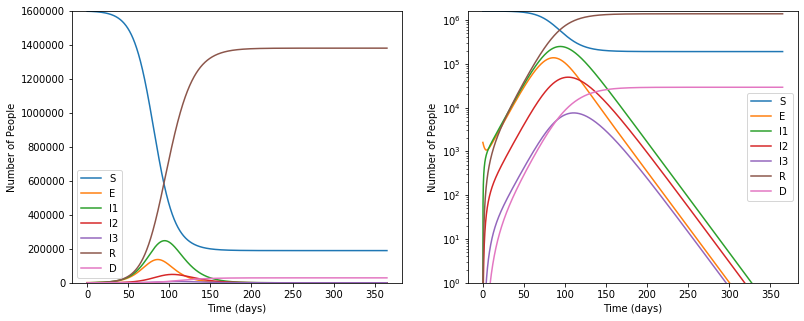

In [10]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSA)
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000*factor])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSA)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000*factor])
#plt.tight_layout()

In [11]:
import pandas as pd



In [12]:
cols = ["Susceptible","Exposed","Mild_infection","Severe_infection","Critical_infection","Recovered","Death"]

dataDf = dict()

dataDf['time'] = tvec

for i, col in enumerate(cols):
    dataDf[col] = solnSA[:,i]

In [13]:
df = pd.DataFrame(dataDf)

In [14]:
df['Total_infection'] = df['Mild_infection'] + df['Severe_infection'] + df['Critical_infection']
df

,time,Susceptible,Exposed,Mild_infection,Severe_infection,Critical_infection,Recovered,Death,Total_infection
0,0.0,1.598400e+06,1600.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
1,0.1,1.598400e+06,1568.710916,31.526319,0.031588,0.000024,1.268083e-01,3.563902e-08,31.557931
2,0.2,1.598398e+06,1538.809407,62.130211,0.124731,0.000189,5.025367e-01,5.461225e-07,62.255131
3,0.3,1.598397e+06,1510.245652,91.847958,0.277072,0.000629,1.120365e+00,2.720297e-06,92.125658
4,0.4,1.598394e+06,1482.971683,120.714519,0.486345,0.001471,1.973741e+00,8.496926e-06,121.202335
...,...,...,...,...,...,...,...,...,...
3645,364.5,1.895669e+05,0.023740,0.113634,0.069498,0.018658,1.381352e+06,2.908108e+04,0.201790
3646,364.6,1.895669e+05,0.023602,0.112974,0.069095,0.018550,1.381352e+06,2.908108e+04,0.200619
3647,364.7,1.895669e+05,0.023465,0.112319,0.068694,0.018442,1.381352e+06,2.908108e+04,0.199454
3648,364.8,1.895669e+05,0.023328,0.111667,0.068295,0.018335,1.381352e+06,2.908108e+04,0.198297


In [15]:
# save to excel
#df.to_excel('series_covid19.xlsx')

# Simulate Social Distancing

In [16]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec,soln,t1,t2,i):
    i1=np.where(tvec==t1)[0][0]
    i2=np.where(tvec==t2)[0][0]
    r=(np.log(soln[i2,1])-np.log(soln[i1,1]))/(t2-t1)
    DoublingTime=np.log(2)/r
    return r, DoublingTime

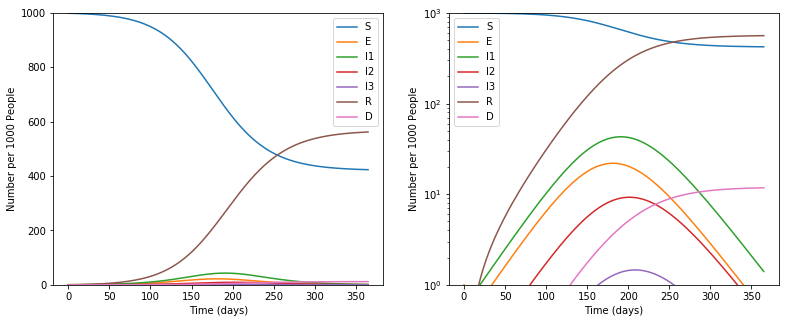

R0 under intervention =  1.5
The epidemic growth rate is = 0.03 per day and the doubling time 23.3 days 


In [17]:
# set variable to a mitigation Social Distancing Strategy
bSlow=0.6*b
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

solnSlow=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N))
solnSlow=np.hstack((N-np.sum(solnSlow,axis=1,keepdims=True),solnSlow))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSlow)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000])

(rSlow,DoublingTimeSlow)=growth_rate(tvec,solnSlow,30,40,1)

plt.show()
print("R0 under intervention = {0:4.1f}".format(R0Slow))
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(rSlow,DoublingTimeSlow))

In [18]:
# multiply SA factor

solnSASlow = solnSlow * factor

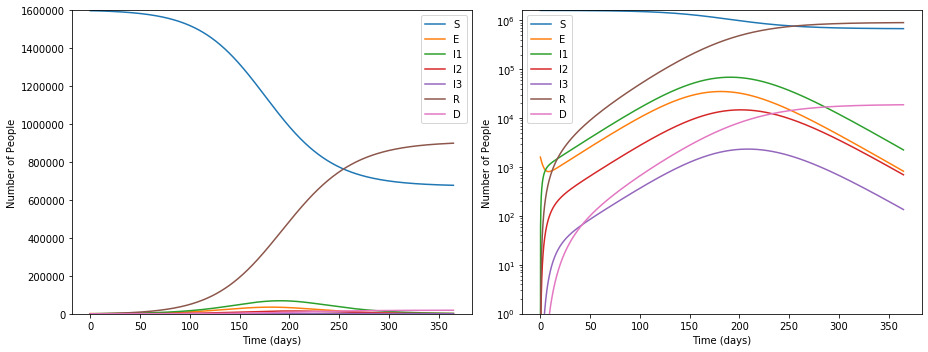

In [19]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSASlow)
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000*factor])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSASlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000*factor])
plt.tight_layout();

In [94]:
cols = ["Susceptible","Exposed","Mild_infection","Severe_infection","Critical_infection","Recovered","Death"]

dataslowDf = dict()

dataslowDf['time'] = tvec

for i, col in enumerate(cols):
    dataslowDf[col] = solnSASlow[:,i]

In [95]:
dfSlow = pd.DataFrame(dataslowDf)
dfSlow['Total_infection'] = dfSlow['Mild_infection'] + dfSlow['Severe_infection'] + dfSlow['Critical_infection']
dfSlow

,time,Susceptible,Exposed,Mild_infection,Severe_infection,Critical_infection,Recovered,Death,Total_infection
0,0.0,1.598400e+06,1600.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,0.1,1.598400e+06,1568.553703,31.525269,0.031588,0.000024,0.126807,3.587486e-08,31.556881
2,0.2,1.598399e+06,1538.190831,62.121937,0.124723,0.000189,0.502504,5.469328e-07,62.246848
3,0.3,1.598398e+06,1508.876394,91.820441,0.277031,0.000629,1.120199,2.721538e-06,92.098100
4,0.4,1.598396e+06,1480.576522,120.650247,0.486216,0.001471,1.973221,8.496201e-06,121.137934
...,...,...,...,...,...,...,...,...,...
3645,364.5,6.776339e+05,832.604316,2270.009168,703.288750,136.959532,899598.326970,1.882490e+04,3110.257449
3646,364.6,6.776207e+05,830.376141,2263.969085,701.437609,136.601803,899621.251709,1.882569e+04,3102.008496
3647,364.7,6.776075e+05,828.153870,2257.944819,699.591211,136.244976,899644.115585,1.882647e+04,3093.781005
3648,364.8,6.775943e+05,825.937486,2251.936330,697.749544,135.889049,899666.918758,1.882724e+04,3085.574923


In [97]:
dfSlow.to_excel('slow.xlsx')

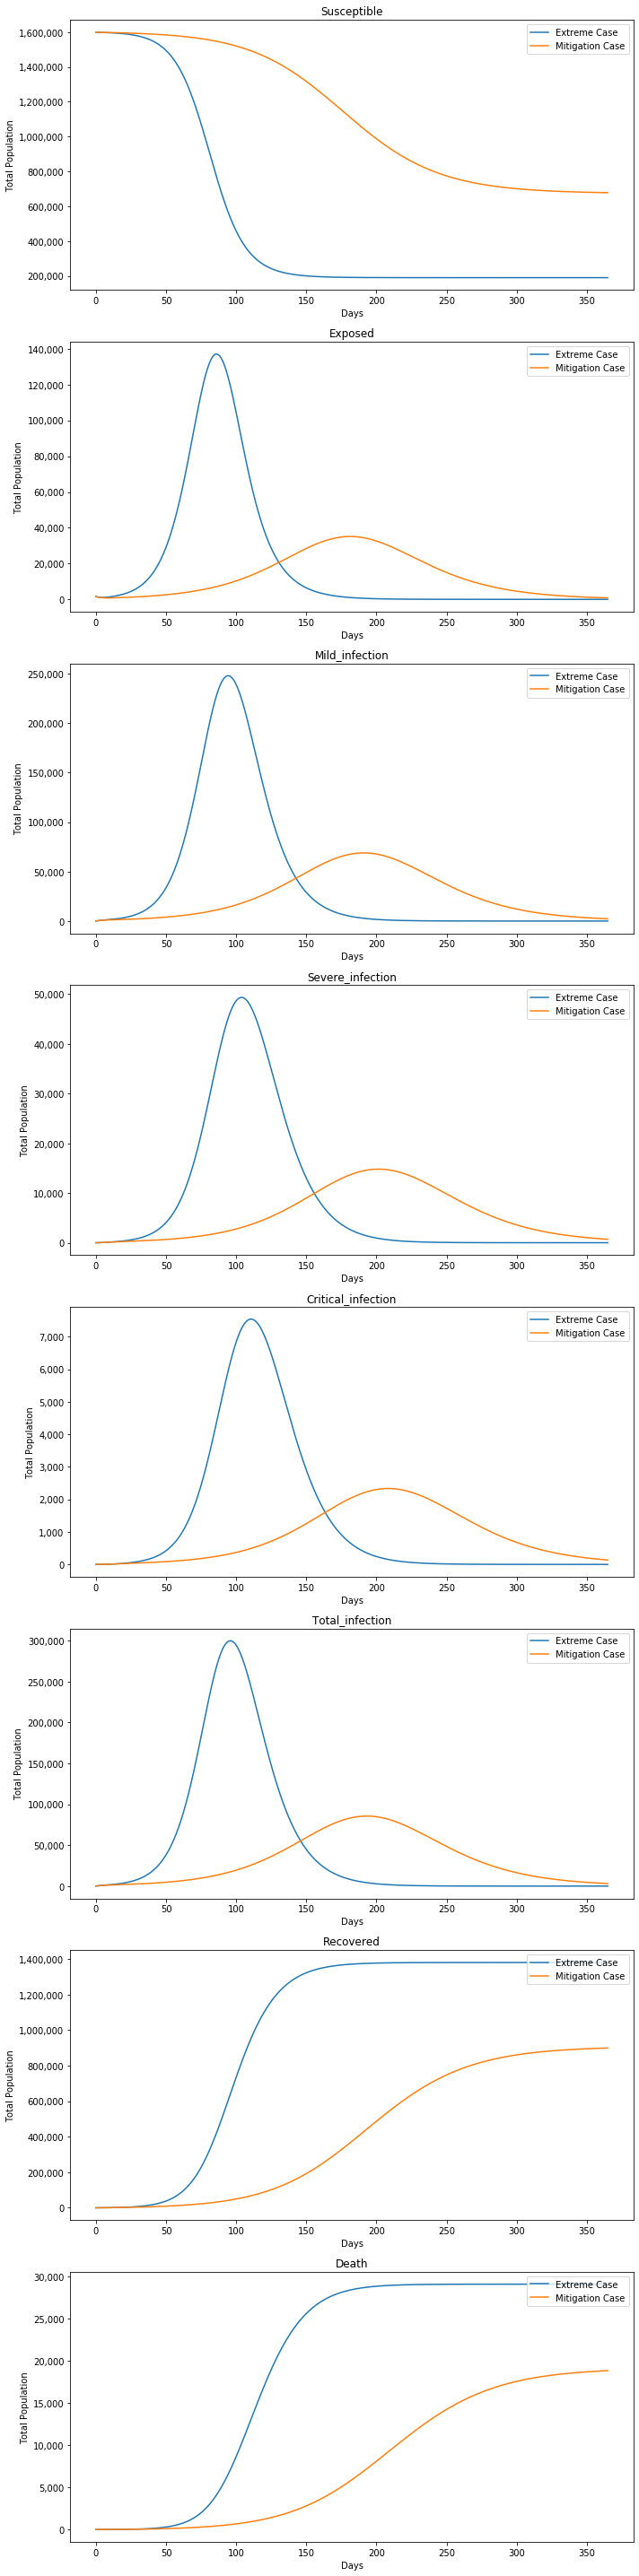

In [22]:
# Plot Stat over time for SA population

cols = ["Susceptible","Exposed","Mild_infection","Severe_infection","Critical_infection","Total_infection","Recovered","Death"]

fig, ax = plt.subplots(len(cols),ncols=1, figsize=(10,40))

for i, col in enumerate(cols):
    ax[i].plot(df['time'],df[f'{col}'],label='Extreme Case')
    ax[i].get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].plot(df['time'],dfSlow[f'{col}'],label='Mitigation Case')
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Total Population')
    ax[i].legend(loc="upper right")
plt.tight_layout()    

In [23]:
# sensitivity analysis for mitigation slow strategy

critical_max = list()
for rate in np.linspace(0.1,1,1000):
    bSlow=rate*b
    R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))
    solnSlow=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N))
    solnSlow=np.hstack((N-np.sum(solnSlow,axis=1,keepdims=True),solnSlow))
    critical_max.append(solnSlow[:,4].max()*factor)

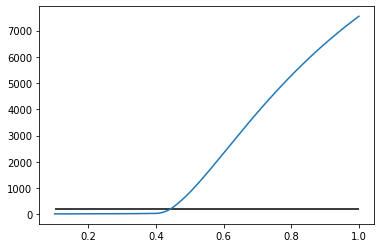

In [24]:
fig, ax = plt.subplots( )
x = np.linspace(0.1,1,1000)
y = critical_max

ax.plot(x,y)
# ax[i].get_yaxis().set_major_formatter(
#     FuncFormatter(lambda x, p: format(int(x), ',')))
# ax[i].plot(df['time'],dfSlow[f'{col}'])
# ax[i].set_title(f'{col}')
# ax[i].set_xlabel('Days')
# ax[i].set_ylabel('Total Population')
plt.hlines(188,x.min(),x.max());

In [25]:
# 0.4405405405405406 188.18496478968342
# check the rate to cap ICU beds
SA_ICU = 188

for i, (rate, critical) in enumerate(zip(x,y)):
    if critical > SA_ICU:
        print(f'ideal rate is between {x[i-1]:.6f} and {rate:.6f}')
        break


ideal rate is between 0.439640 and 0.440541


In [26]:
# redo slow using 0.439640 multiple Ideal case


# set variable to a mitigation Social Distancing Strategy
bSlow= 0.439640 *b
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

solnSlow_ideal=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N))
solnSlow_ideal=np.hstack((N-np.sum(solnSlow_ideal,axis=1,keepdims=True),solnSlow_ideal))

# multiply SA factor

solnSASlow_ideal = solnSlow_ideal * factor

In [27]:
cols = ["Susceptible","Exposed","Mild_infection","Severe_infection","Critical_infection","Recovered","Death"]

dataslowIdeal = dict()

dataslowIdeal['time'] = tvec

for i, col in enumerate(cols):
    dataslowIdeal[col] = solnSASlow_ideal[:,i]

In [28]:
dfSlow_ideal = pd.DataFrame(dataslowIdeal)
dfSlow_ideal['Total_infection'] = (dfSlow_ideal['Mild_infection'] + dfSlow_ideal['Severe_infection']
                                   + dfSlow_ideal['Critical_infection'])
dfSlow_ideal

,time,Susceptible,Exposed,Mild_infection,Severe_infection,Critical_infection,Recovered,Death,Total_infection
0,0.0,1.598400e+06,1600.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,0.1,1.598400e+06,1568.490677,31.524848,0.031588,0.000024,0.126807,3.603916e-08,31.556460
2,0.2,1.598399e+06,1537.942867,62.118619,0.124720,0.000189,0.502491,5.477157e-07,62.243528
3,0.3,1.598398e+06,1508.327573,91.809411,0.277014,0.000629,1.120133,2.722380e-06,92.087054
4,0.4,1.598397e+06,1479.616660,120.624485,0.486165,0.001471,1.973013,8.496679e-06,121.112121
...,...,...,...,...,...,...,...,...,...
3645,364.5,1.484200e+06,2708.915368,5344.244958,1155.015738,181.477257,104382.991805,2.027681e+03,6680.737953
3646,364.6,1.484147e+06,2709.224130,5344.980234,1155.203966,181.509742,104433.624417,2.028718e+03,6681.693942
3647,364.7,1.484094e+06,2709.532268,5345.714332,1155.391952,181.542192,104484.264192,2.029756e+03,6682.648476
3648,364.8,1.484041e+06,2709.839784,5346.447252,1155.579698,181.574604,104534.911120,2.030793e+03,6683.601554


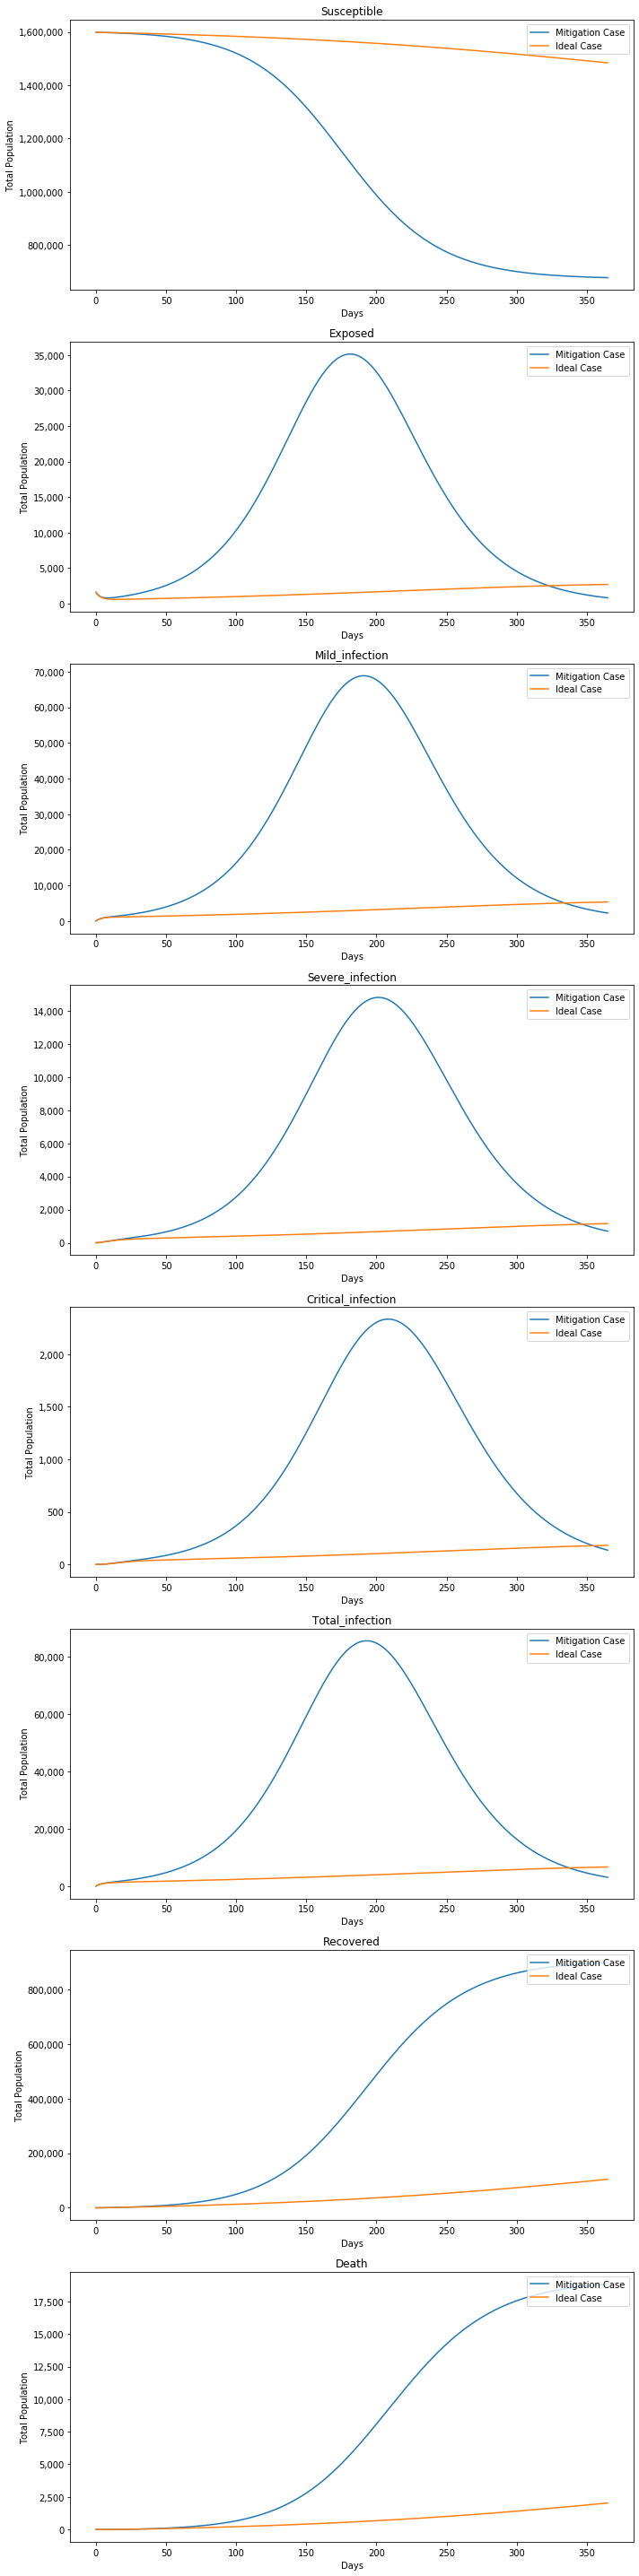

In [31]:
# Plot Stat over time for SA population for Slow and Slow Ideal

cols = ["Susceptible","Exposed","Mild_infection","Severe_infection","Critical_infection","Total_infection","Recovered","Death"]

fig, ax = plt.subplots(len(cols),ncols=1, figsize=(10,40))

for i, col in enumerate(cols):
    ax[i].plot(df['time'],dfSlow[f'{col}'],label='Mitigation Case')
    ax[i].get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].plot(df['time'],dfSlow_ideal[f'{col}'],label='Ideal Case')
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Total Population')
    ax[i].legend(loc="upper right")
plt.tight_layout()

In [30]:
#dfSlow_ideal.to_excel('ideal.xlsx')

In [32]:
# import latest data from GitHub
import io
import requests
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
r=requests.get(url).content
covid_series =pd.read_csv(io.StringIO(r.decode('utf-8')))

In [77]:
covid_SA = covid_series[covid_series['Province/State']=='South Australia']
covid_SA = covid_SA.drop(columns=['Country/Region','Lat','Long'])
covid_SA = covid_SA.melt(id_vars='Province/State')
covid_SA.rename(columns={'variable':'date','value':'cases'}, inplace=True)
covid_SA.loc[:,'date'] = covid_SA['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))


In [78]:
# cases from day 1
covid_SA = covid_SA[covid_SA['cases']>0]
covid_SA['day'] = [i+1 for i in range(len(covid_SA))]

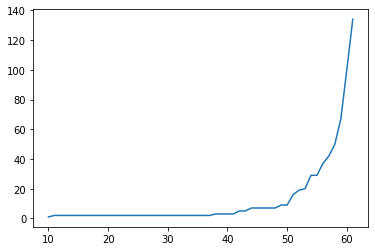

In [79]:
covid_SA['cases'].plot();

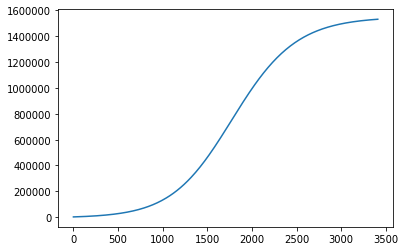

In [134]:
# # REVERSE engineer cummulative infected

# dfSlow_daily = dfSlow.iloc[[i for i in dfSlow.index if i%10 ==0],:]
# dfSlow_daily.loc[:,'Recovered_mild'] = dfSlow_daily['Recovered'].apply(lambda x: x * (.8/.95)) 
# dfSlow_daily.loc[:,'Recovered_severe'] = dfSlow_daily['Recovered'].apply(lambda x: x * (.15/.95))
# dfSlow_daily.loc[:, 'Infected_mild'] = dfSlow_daily['Recovered_mild'].shift(-15)
# dfSlow_daily.loc[:, 'Infected_severe'] = dfSlow_daily['Recovered_mild'].shift(-16)
# dfSlow_daily.loc[:, 'Infected_death'] = dfSlow_daily['Death'].shift(-23)
# dfSlow_daily.loc[:,'CummCases'] = (dfSlow_daily['Infected_mild'] + 
#                              dfSlow_daily['Infected_severe'] + dfSlow_daily['Infected_death'])

# dfSlow_daily['CummCases'].plot();

In [135]:
covid_SA['cases']

10      1
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      2
21      2
22      2
23      2
24      2
25      2
26      2
27      2
28      2
29      2
30      2
31      2
32      2
33      2
34      2
35      2
36      2
37      2
38      3
39      3
40      3
41      3
42      5
43      5
44      7
45      7
46      7
47      7
48      7
49      9
50      9
51     16
52     19
53     20
54     29
55     29
56     37
57     42
58     50
59     67
60    100
61    134
Name: cases, dtype: int64